## Tensorflow Tutorial 5: Word2Vec

機器有辦法自行從文本中觀察出詞彙間的相似度嗎？是可以的，word2vec是"word to vector"的縮寫，代表的正是將每個字轉換成向量，而一旦兩個字的向量越是靠近，就代表它的相似度越高，我們究竟要如何得到這些向量呢？方法簡單但出奇有效，文章的最後會向大家呈現它的精彩的結果。

本單元程式碼Skip-Gram Word2Vec部分可於[Github](https://github.com/GitYCC/Tensorflow_Tutorial/blob/master/code/05_1_word2vec_SkipGram.py)下載，CBOW Word2Vec部分可於[Github](https://github.com/GitYCC/Tensorflow_Tutorial/blob/master/code/05_2_word2vec_CBOW.py)下載。


### Word2Vec觀念解析

Word2Vec的形式和Autoencoder有點像，一樣是從高維度的空間轉換到低維度的空間，再轉換回去原本的維度，只是這一次轉回去的東西不再是原本一模一樣的東西了。

Word2Vec的Input和Output這次變成是上下文的文字組合，舉個例子，"by the way"這個用法如果多次被機器看過的話，機器是有辦法去學習到這樣的規律的，此時"by"與"the"和"way"便會產生一個上下文的關聯性，為了將這樣的關聯性建立起來，我們希望當我輸入"by"時，機器有辦法預測並輸出"the"或"way"，這代表在機器內部它已經學習到了上下文的關聯性。

那如果今天這個機器也同時看到很多次的"on the way"這種用法，所以當我輸入"on"時，機器要有辦法預測並輸出"the"或"way"，但是我們不希望"on"和"by"兩個詞在學習時是分開學習的，我們希望機器可以因為"by the way"和"on the way"的結構很相似，所以有辦法抓出"on"和"by"是彼此相似的結論。

如何做到呢？答案就是限縮這個上下文的關聯性的儲存維度，如果我的字彙量有1000個，這1000個字彙彼此有上下文的關聯性，最完整表示上下文關聯性的方法就是設置一個1000x1000或者更大的表格，把所有字彙間的上下文關聯性全部存起來，但我們不想要這麼做，我要求機器用更小的表格來儲存上下文的關聯性，此時機器被迫將一些詞彙使用同樣的表格位置，同樣的轉換。一旦限縮了上下文關聯性的儲存維度，"on the way"和"by the way"中的"on"和"by"就會被迫分為同一類，因此我們成功的建立了字詞間的相似性關係。

### Word2Vec的架構

![word2vec](https://raw.githubusercontent.com/GitYCC/Tensorflow_Tutorial/master/img/TensorflowTutorial.008.jpeg)

實作上如上圖所示，我們輸入一個字詞，譬如"cat"，通常會將他轉成One-hot encoding表示，但要注意喔！文本的字彙量是非常龐大的，所以當我們使用One-hot encoding表示時，將會出現一個非常長但Sparse的向量，相同的輸出層也同樣是一個很長的One-hot encoding，它的維度會和輸入層一樣大，因為我們要分析的字彙在輸入和輸出是一樣多的。

然後，和Autoencoder使用一樣的手法，中間的Hidden Layer放置低維度、少神經元的一層，但不同於Autoencoder，Word2Vec所有的轉換都是線性的，沒有非線性的Activation Function夾在其中，為什麼呢？因為我們的輸入是Sparse的而且只有0和1的差別，所以每一條通路就變成只有導通或不導通的差別，Activation Function有加等於沒加，使用線性就足夠了。

這個中間的Hidden Layer被稱為Embedding Matrix，它做了一個線性的Dimension Reduction，將原本高維度的One-hot encoding降低成低維度，然後再透過一個線性模型轉換回去原本的維度。假設字彙的數量有N個，所以輸入矩陣X是一個1xN的矩陣，輸出的矩陣同樣也是1xN的矩陣，當我先做一個線性的Dimension Reduction，將維度降到d維，此時Embedding Matrix會是一個Nxd的矩陣V，然後再由線性模型轉換回去原本的維度，這個轉換矩陣W是一個Nxd矩陣，因此綜合上述，可用一個簡潔的表示式表示：Y=W<sup>T</sup>VX，我們的目標就是找出這個W和V矩陣的每個元素。

你會想說線性模型很簡單啊！就是仿照Autoencoder的作法，然後把Activation Function拿掉不就了事了，並且因為輸出是One-hot Encoding所以最後套用Softmax，那不就輕鬆完成！但是真正的大魔王就出在字彙量，字彙量一旦很大，事情就變得不可收拾了，而且字彙量是一定小不得的，那怎麼辦？

在Dimension Reduction我們可以採取一個快速的方法，因為除了我要表示的字的位置是1以外其他都是0，所以其他都可以不看，我們就直接看是在第幾個位置上是1，然後再到Embedding Matrix上找到相應的行直接取出就是答案了，這樣查詢的動作，在Tensorflow中可以使用`tf.nn.embedding_lookup`來辦到。

再接下來最後的Cross-Entropy Loss計算也非常龐大，因為有幾個字彙就需要累加幾組數字，我們有一招偷吃步的方法叫做「Sampled Softmax」，作法是這樣的，我們不去計算全部詞彙的Cross-Entropy，而是選擇幾組詞彙來評估Cross-Entropy，在選擇上我們會隨機挑選一些Labels和預測結果差異度很大的詞彙(稱為Negative Examples)來算Cross-Entropy，我們在Tensorflow可以使用`tf.nn.sampled_softmax_loss`來辦到「Sampled Softmax」。

我們先不管輸入和輸出究竟怎麼取得，如果我們成功的建立了輸入和輸出的上下文關係，此時中間的Embedding空間正是精華的所在，經過剛剛推論，我們預期在這個空間當中，相似的詞彙會彼此靠近，我們評估兩個向量的相似性可以使用Cosine來評估，當兩向量的夾角越小代表它們越是相似，待會的實作當中我們將會利用Cosine來建立Similarity的大小，藉此來找到前幾個和它很靠近的詞彙。

另外，經研究指出這個Embedding空間的效果不只是可以算出詞彙間的相似性，還可以顯示詞彙間的比較關係，例如：北京之於中國，等同於台北之於台灣，這樣的比較關係也顯示在這個Embedding空間裡頭，所以在這空間裡會有以下的向量關係式：V<sub>北京</sub>-V<sub>中國</sub>+V<sub>台灣</sub>=V<sub>台北</sub>，是不是很神奇啊！

### Word2Vec的兩種常用方法：Skip-Gram和CBOW

![Skip-Gram和CBOW](https://raw.githubusercontent.com/GitYCC/Tensorflow_Tutorial/master/img/TensorflowTutorial.009.jpeg)

剛剛一直在講的是中間的結構應該怎麼建立，現在來看看我們可以輸入和輸出哪些詞彙來建立起上下文的關係，有兩種常用的類別：Skip-Gram和CBOW。

Skip-Gram如上圖所示，當我輸入一個word(t)時，我希望它能輸出它的前文和後文，這是相當直覺的建立上下文的方法，所以如果我希望用前一個字和後一個字來訓練我的Word2Vec，我就會有兩組數據：(w(t),w(t-1))和(w(t),w(t+1))，相當好理解。

而CBOW(Continuous Bag of Words)使用另外一種方法來建立上下文關係，它將一排字挖掉中間一個字，然後希望由上下文的關係有辦法猜出中間那個字，就像是填空題，此時輸入層就變成會有多於1個字，那該怎麼處理，答案是轉換到Embedding空間後再相加平均，因為是線性轉換，所以直接線性累加就可以了。

### 準備文本語料庫

先帶入一些待會會用到的函式庫，並且決定我們要取用多少`VOCABULARY_SIZE`個詞彙量來做訓練。

In [1]:
%matplotlib inline
from __future__ import print_function
from __future__ import generators
import collections
import os
import zipfile
from six.moves.urllib.request import urlretrieve
import tensorflow as tf
import numpy as np
import random
import math
import time

VOCABULARY_SIZE = 100000

接下來下載Dataset，並做一些前處理。

In [2]:
def maybe_download(url,filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
def build_dataset(words,vocabulary_size=VOCABULARY_SIZE):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

print("Downloading text8.zip")
filename = maybe_download('http://mattmahoney.net/dc/text8.zip','./text8.zip', 31344016)

print("=====")
words = read_data(filename)
print('Data size %d' % len(words))
print('First 10 words: {}'.format(words[:10]))

print("=====")
data, count, dictionary, reverse_dictionary = build_dataset(words,
                                                            vocabulary_size=VOCABULARY_SIZE)
del words  # Hint to reduce memory.

print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])

Found and verified ./text8.zip
=====
Data size 17005207
First 10 words: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']
=====
Most common words (+UNK) [['UNK', 189230], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


我們取用`VOCABULARY_SIZE = 100000`，也是說我們將文本中的詞彙按出現次數的多寡來排列，取前面`VOCABULARY_SIZE`個保留，其餘詞彙皆歸類到「UNK Token」裡頭，UNK代表UNKnown的縮寫。

我們文本的字詞數量總共有17005207個字，開頭前十個字的句子是'anarchism originated as a term of abuse first used against'。所有的這17005207個字會依照`dictionary`給予每個字Index，而文本會被表示為一個由整數所構成的List，這會放在`data`裡頭，而這個Index也就直接當作One-hot Encoding中代表這個詞彙的維度位置。當我想要把Index轉換回去我們看得懂的字的時候，就需要`reverse_dictionary`的幫忙，有了這些，我們的語料庫就已經建立完成了。

### 實作Skip-Gram

有了語料庫，我們就可以產生出我想要的輸入和輸出，在Skip-Gram方法，如果我的輸入是`target word`，我會先從`target word`向前、向後看出去`skip_window`的大小，所以可以選擇當作輸出的字有`skip_window*2`個，接下來我從這`skip_window*2`個中選擇`num_skips`個當作輸出，所以一個`target word`會產生`num_skips`筆數據，如果我一個batch需要`batch_size`筆數據，我就必須有`batch_size//num_skips`個`target word`，依照這樣的規則下面建立一個Generator來掃描文本，並輸出要訓練使用的Batch Data。

In [3]:
def skip_gram_batch_generator(data,batch_size,num_skips,skip_window):
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    
    # initialization
    data_index = 0
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    
    # generate
    k = 0
    while True:
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ target ]
        for _ in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[k] = buffer[skip_window]
            labels[k, 0] = buffer[target]
            k += 1
            
        # Recycle 
        if data_index == len(data): data_index = 0
        
        # scan data
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        
        # Enough num to output
        if k == batch_size:
            k = 0
            yield (batch.copy(), labels.copy())

# demonstrate generator
print('data:', [reverse_dictionary[di] for di in data[:10]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    batch_generator = skip_gram_batch_generator(data=data,batch_size=8,num_skips=num_skips,skip_window=skip_window)
    batch, labels = next(batch_generator)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'originated', 'a', 'as', 'term', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['term', 'anarchism', 'originated', 'a', 'originated', 'term', 'as', 'of']


In [4]:
class SkipGram(object):
    def __init__(self,n_vocabulary,n_embedding,reverse_dictionary,learning_rate=1.0):
        self.n_vocabulary = n_vocabulary
        self.n_embedding = n_embedding
        self.reverse_dictionary = reverse_dictionary
        
        self.weights = None
        self.biases = None
        
        self.graph = tf.Graph() # initialize new grap
        self.build(learning_rate) # building graph
        self.sess = tf.Session(graph=self.graph) # create session by the graph 
        
    def build(self,learning_rate):
        with self.graph.as_default():
            ### Input
            self.train_dataset = tf.placeholder(tf.int32, shape=[None])
            self.train_labels  = tf.placeholder(tf.int32, shape=[None, 1])

            ### Optimalization
            # build neurel network structure and get their loss
            self.loss = self.structure( dataset=self.train_dataset,
                                        labels=self.train_labels,
                                      )
            
            # normalize embeddings
            self.norm = tf.sqrt(
                          tf.reduce_sum(
                            tf.square(self.weights['embeddings']), 1, keep_dims=True))
            self.normalized_embeddings = self.weights['embeddings'] / self.norm
            
            # define training operation
            self.optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(self.loss)
            
            ### Prediction
            self.new_dataset = tf.placeholder(tf.int32, shape=[None])
            self.new_labels  = tf.placeholder(tf.int32, shape=[None, 1])
            self.new_loss = self.structure( dataset=self.new_dataset,
                                            labels=self.new_labels,
                                          )
            
            # similarity
            self.new_embed = tf.nn.embedding_lookup(
                               self.normalized_embeddings, self.new_dataset)
            self.new_similarity = tf.matmul(self.new_embed, 
                                            tf.transpose(self.normalized_embeddings))
            
            ### Initialization
            self.init_op = tf.global_variables_initializer()  
    
    def structure(self,dataset,labels):
        ### Variable
        if (not self.weights) and (not self.biases):
            self.weights = {
                'embeddings': tf.Variable(
                                tf.random_uniform([self.n_vocabulary, self.n_embedding], 
                                                  -1.0, 1.0)),
                'softmax': tf.Variable(
                             tf.truncated_normal([self.n_vocabulary, self.n_embedding],
                               stddev=1.0 / math.sqrt(self.n_embedding)))
            }
            self.biases = {
                'softmax': tf.Variable(tf.zeros([self.n_vocabulary]))
            }
                              

        ### Structure
        # Look up embeddings for inputs.
        embed = tf.nn.embedding_lookup(self.weights['embeddings'], dataset)
        
        # Compute the softmax loss, using a sample of the negative labels each time.
        num_softmax_sampled = 64
        
        loss = tf.reduce_mean(
                 tf.nn.sampled_softmax_loss(weights=self.weights['softmax'], 
                                            biases=self.biases['softmax'], 
                                            inputs=embed,
                                            labels=labels, 
                                            num_sampled=num_softmax_sampled, 
                                            num_classes=self.n_vocabulary))

        return loss
    
    
    def initialize(self):
        self.weights = None
        self.biases = None
        self.sess.run(self.init_op)
    
    def online_fit(self,X,Y):      
        feed_dict = {self.train_dataset: X,
                     self.train_labels: Y}
        _, loss = self.sess.run([self.train_op, self.loss], feed_dict=feed_dict)
        
        return loss
    
    def nearest_words(self,X,top_nearest):
        similarity = self.sess.run(self.new_similarity,
                                   feed_dict={self.new_dataset: X})
        X_size = X.shape[0]
        
        valid_words = []
        nearests = []
        for i in range(X_size):
            valid_word = self.find_word(X[i])
            valid_words.append(valid_word)    
            
            # select highest similarity word
            nearest = (-similarity[i, :]).argsort()[1:top_nearest+1]  
            nearests.append(list(map(lambda x:self.find_word(x),nearest)))
            
        return (valid_words,np.array(nearests))
    
    def evaluate(self,X,Y):
        return self.sess.run(self.new_loss, feed_dict={self.new_dataset: X,
                                                       self.new_labels: Y})
    
    def embedding_matrix(self):
        return self.sess.run(self.normalized_embeddings)
    
    def find_word(self,index):
        return self.reverse_dictionary[index]

以上就是我建立的Model，這裡我採取`online_fit`的方法，不同於之前的`fit`，`online_fit`可以不用事先將所有Data一次餵進去，而是可以陸續的餵入Data，所以我會從上面的Generator陸續產生Batch Data並餵入Model裡來做訓練。

In [5]:
# build skip-gram batch generator
batch_generator = skip_gram_batch_generator(data=data,
                                            batch_size=128,
                                            num_skips=2,
                                            skip_window=1)

# build skip-gram model
model_SkipGram = SkipGram(n_vocabulary=VOCABULARY_SIZE,
                          n_embedding=100,
                          reverse_dictionary=reverse_dictionary,
                          learning_rate=1.0)
# initial model
model_SkipGram.initialize()

# online training
epochs = 50
num_batchs_in_epoch = 5000

for epoch in range(epochs):
    start_time = time.time()
    avg_loss = 0
    for _ in range(num_batchs_in_epoch):
        batch, labels = next(batch_generator)
        loss = model_SkipGram.online_fit(X=batch,
                                         Y=labels)
        avg_loss += loss
    avg_loss = avg_loss / num_batchs_in_epoch
    print("Epoch %d/%d: %ds loss = %9.4f" % ( epoch+1, epochs, time.time()-start_time,
                                                   avg_loss ))

Epoch 1/50: 18s loss =    4.2115
Epoch 2/50: 17s loss =    3.7554
Epoch 3/50: 15s loss =    3.6211
Epoch 4/50: 15s loss =    3.5072
Epoch 5/50: 15s loss =    3.5084
Epoch 6/50: 15s loss =    3.4988
Epoch 7/50: 15s loss =    3.5165
Epoch 8/50: 15s loss =    3.3949
Epoch 9/50: 15s loss =    3.4382
Epoch 10/50: 15s loss =    3.4121
Epoch 11/50: 15s loss =    3.4027
Epoch 12/50: 15s loss =    3.4074
Epoch 13/50: 15s loss =    3.3222
Epoch 14/50: 15s loss =    3.3448
Epoch 15/50: 16s loss =    3.3616
Epoch 16/50: 15s loss =    3.3389
Epoch 17/50: 15s loss =    3.3729
Epoch 18/50: 15s loss =    3.3911
Epoch 19/50: 15s loss =    3.3512
Epoch 20/50: 15s loss =    3.3107
Epoch 21/50: 16s loss =    3.3046
Epoch 22/50: 15s loss =    3.3103
Epoch 23/50: 15s loss =    3.3042
Epoch 24/50: 15s loss =    3.2634
Epoch 25/50: 15s loss =    3.3181
Epoch 26/50: 15s loss =    3.2808
Epoch 27/50: 15s loss =    3.2464
Epoch 28/50: 15s loss =    3.2246
Epoch 29/50: 15s loss =    3.2666
Epoch 30/50: 15s loss =

我們來看看效果如何，我們使用Embedding Vectors彼此間的Cosine來定義出字詞間的相關性，並且列出8個最為靠近的字詞。

In [6]:
valid_words_index = np.array([10,20,30,40,50,210,239,392,396])

valid_words, nearests = model_SkipGram.nearest_words(X=valid_words_index,top_nearest=8)
for i in range(len(valid_words)):
    print("Nearest to '{}': ".format(valid_words[i]),nearests[i])

Nearest to 'two':  ['three' 'four' 'five' 'eight' 'six' 'seven' 'nine' 'one']
Nearest to 'that':  ['which' 'however' 'eophona' 'clemency' 'invariants' 'ratchet' 'what'
 'fiona']
Nearest to 'his':  ['her' 'their' 'my' 'your' 'its' 'our' 'thy' 'witchcraft']
Nearest to 'were':  ['are' 'was' 'include' 'have' 'cyanobacterial' 'seem' 'be' 'those']
Nearest to 'all':  ['both' 'various' 'many' 'counting' 'some' 'every' 'several' 'risked']
Nearest to 'area':  ['region' 'areas' 'suctoria' 'regions' 'island' 'pwned' 'territory'
 'plains']
Nearest to 'east':  ['west' 'eastern' 'southeast' 'south' 'southwest' 'curable' 'north'
 'hispaniolan']
Nearest to 'himself':  ['him' 'themselves' 'them' 'itself' 'megalith' 'herself' 'successfully'
 'armas']
Nearest to 'white':  ['red' 'black' 'blue' 'yellow' 'green' 'overdraft' 'horse' 'dark']


結果相當驚人，與'two'靠近的真的都是數字類型的文字，與'that'靠近的都是文法功能性的詞彙，與'his'靠近的都是所有格代名詞，與'were'靠近的是be動詞，與'all'最靠近的是'both'，與'east'靠近的都是一些代表方向的詞彙，與'white'靠近的都是一些顏色的詞彙，真的是太神奇了！

接下來直接來觀察Embedding空間，以下使用t-SNE來圖像化Embedding空間。

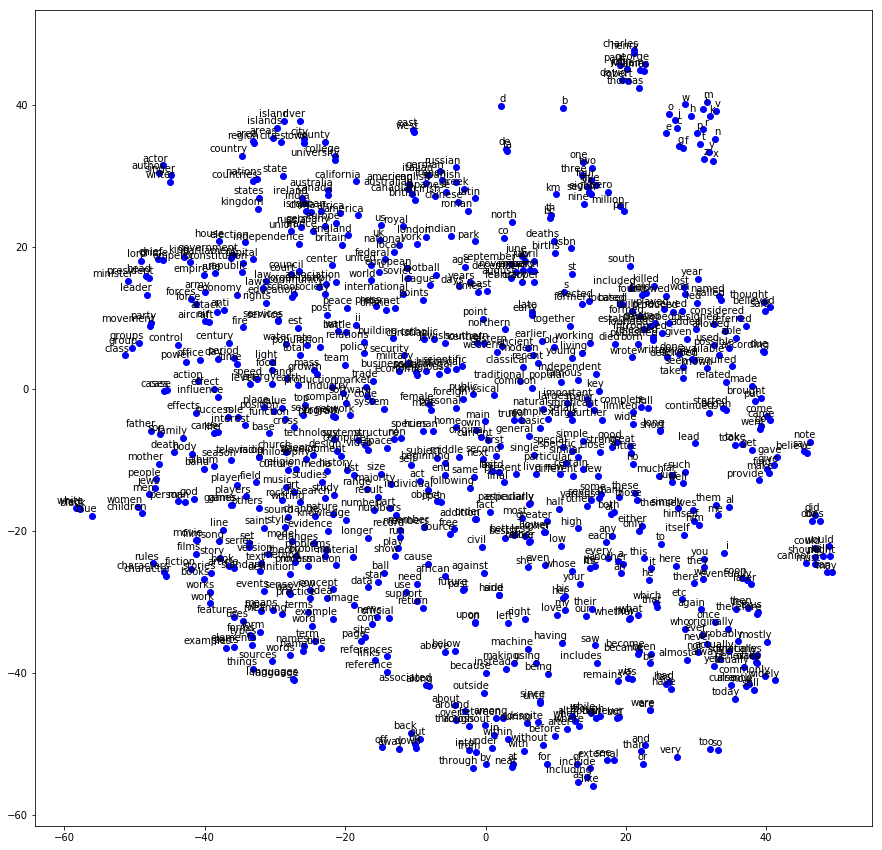

In [7]:
from matplotlib import pylab
from sklearn.manifold import TSNE

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y, color="blue")
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

visualization_words = 800
# transform embeddings to 2D by t-SNE
embed = model_SkipGram.embedding_matrix()[1:visualization_words+1,:]
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embed = tsne.fit_transform(embed)
# list labels
words = [model_SkipGram.reverse_dictionary[i] for i in range(1, visualization_words+1)]
# plot
plot(two_d_embed,words)

如此一來你將可以簡單的看出，哪些詞彙彼此相似而靠近。

### 實作CBOW (Continuous Bag of Words)

接著看CBOW的方法，如果我預期輸出的字是`target word`，從`target word`向前向後看出去`context_window`的大小，看到的字都當作我的輸入，所以我輸入的字總共需要`context_window*2`個，一個`target word`只會產生一筆數據，如果我一個batch需要`batch_size`筆數據，我就必須有`batch_size`個`target word`，依照這樣的規則下面建立一個Generator來掃描文本，並輸出要訓練使用的Batch Data。

In [8]:
def cbow_batch_generator(data,batch_size,context_window):
    span = 2 * context_window + 1 # [ context_window target context_window ]
    num_bow = span - 1
    
    batch = np.ndarray(shape=(batch_size, num_bow), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    buffer = collections.deque(maxlen=span)
    
    # initialization
    data_index = 0
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    # generate
    k = 0
    target = context_window
    while True:        
        bow = list(buffer)
        del bow[target]
        for i,w in enumerate(bow):
            batch[k,i] = w
        labels[k,0] = buffer[target]
        k += 1
        
        # Recycle 
        if data_index == len(data): data_index = 0
        
        # scan data
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        
        # Enough num to output
        if k == batch_size:
            k = 0
            yield (batch, labels)
        
        
            
# demonstrate generator
print('data:', [reverse_dictionary[di] for di in data[:10]])

for context_window in [1, 2]:
    batch_generator = cbow_batch_generator(data=data,
                                           batch_size=8,
                                           context_window=context_window)
    batch, labels = next(batch_generator)

    print('\nwith context_window = %d:' % (context_window))
    print('batch:')
    show_batch = []
    for i in range(batch.shape[0]):
        tmp = []
        for j in range(batch.shape[1]):
            tmp.append(reverse_dictionary[batch[i,j]])
        show_batch.append(tmp)
    print(show_batch)
    print('labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']

with context_window = 1:
batch:
[['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used'], ['first', 'against']]
labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with context_window = 2:
batch:
[['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first'], ['term', 'of', 'first', 'used'], ['of', 'abuse', 'used', 'against'], ['abuse', 'first', 'against', 'early'], ['first', 'used', 'early', 'working']]
labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [9]:
class CBOW(object):
    def __init__(self,n_vocabulary,n_embedding,context_window,reverse_dictionary,learning_rate=1.0):
        self.n_vocabulary = n_vocabulary
        self.n_embedding = n_embedding
        self.context_window = context_window
        self.reverse_dictionary = reverse_dictionary
        
        self.weights = None
        self.biases = None
        
        self.graph = tf.Graph() # initialize new grap
        self.build(learning_rate) # building graph
        self.sess = tf.Session(graph=self.graph) # create session by the graph 
        
    def build(self,learning_rate):
        with self.graph.as_default():
            ### Input
            self.train_dataset = tf.placeholder(tf.int32, shape=[None, self.context_window*2])
            self.train_labels  = tf.placeholder(tf.int32, shape=[None, 1])

            ### Optimalization
            # build neurel network structure and get their predictions and loss
            self.loss = self.structure( dataset=self.train_dataset,
                                        labels=self.train_labels,
                                      )
            
            # normalize embeddings
            self.norm = tf.sqrt(
                          tf.reduce_sum(
                            tf.square(self.weights['embeddings']), 1, keep_dims=True))
            self.normalized_embeddings = self.weights['embeddings'] / self.norm
            
            # define training operation
            self.optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(self.loss)
            
            ### Prediction
            self.new_dataset = tf.placeholder(tf.int32, shape=[None])
            self.new_labels  = tf.placeholder(tf.int32, shape=[None, 1])
            
            # similarity
            self.new_embed = tf.nn.embedding_lookup(
                               self.normalized_embeddings, self.new_dataset)
            
            self.new_similarity = tf.matmul(self.new_embed, 
                                            tf.transpose(self.normalized_embeddings))
            
            ### Initialization
            self.init_op = tf.global_variables_initializer()  
    
    def structure(self,dataset,labels):
        ### Variable
        if (not self.weights) and (not self.biases):
            self.weights = {
                'embeddings': tf.Variable(
                                tf.random_uniform([self.n_vocabulary, self.n_embedding],
                                                  -1.0, 1.0)),
                'softmax': tf.Variable(
                             tf.truncated_normal([self.n_vocabulary, self.n_embedding],
                               stddev=1.0 / math.sqrt(self.n_embedding)))
            }
            self.biases = {
                'softmax': tf.Variable(tf.zeros([self.n_vocabulary]))
            }
                              

        ### Structure
        # Look up embeddings for inputs.
        embed_bow = tf.nn.embedding_lookup(self.weights['embeddings'], dataset)
        embed = tf.reduce_mean(embed_bow,axis=1)
        
        # Compute the softmax loss, using a sample of the negative labels each time.
        num_softmax_sampled = 64
        
        loss = tf.reduce_mean(
                 tf.nn.sampled_softmax_loss(weights=self.weights['softmax'], 
                                            biases=self.biases['softmax'], 
                                            inputs=embed,
                                            labels=labels, 
                                            num_sampled=num_softmax_sampled, 
                                            num_classes=self.n_vocabulary))

        return loss
    
    
    def initialize(self):
        self.weights = None
        self.biases = None
        self.sess.run(self.init_op)
    
    def online_fit(self,X,Y):      
        feed_dict = {self.train_dataset: X,
                     self.train_labels: Y}
        _, loss = self.sess.run([self.train_op, self.loss], feed_dict=feed_dict)
        
        return loss
    
    def nearest_words(self,X,top_nearest):
        similarity = self.sess.run(self.new_similarity, feed_dict={self.new_dataset: X})
        X_size = X.shape[0]
        
        valid_words = []
        nearests = []
        for i in range(X_size):
            valid_word = self.find_word(X[i])
            valid_words.append(valid_word)    
            
            # select highest similarity word
            nearest = (-similarity[i, :]).argsort()[1:top_nearest+1]
            nearests.append(list(map(lambda x:self.find_word(x),nearest)))
            
        return (valid_words,np.array(nearests))
    
    def evaluate(self,X,Y):
        return self.sess.run(self.new_loss, feed_dict={self.new_dataset: X,
                                                       self.new_labels: Y})
    
    def embedding_matrix(self):
        return self.sess.run(self.normalized_embeddings)
    
    def find_word(self,index):
        return self.reverse_dictionary[index]

In [10]:
context_window = 1

# build CBOW batch generator
batch_generator = cbow_batch_generator(data=data,
                                       batch_size=128,
                                       context_window=context_window)

# build CBOW model
model_CBOW = CBOW(n_vocabulary=VOCABULARY_SIZE,
                  n_embedding=100,
                  context_window=context_window,
                  reverse_dictionary=reverse_dictionary,
                  learning_rate=1.0)

# initialize model
model_CBOW.initialize()

# online training
epochs = 50
num_batchs_in_epoch = 5000

for epoch in range(epochs):
    start_time = time.time()
    avg_loss = 0
    for _ in range(num_batchs_in_epoch):
        batch, labels = next(batch_generator)
        loss = model_CBOW.online_fit(X=batch,
                                     Y=labels)
        avg_loss += loss
    avg_loss = avg_loss / num_batchs_in_epoch
    print("Epoch %d/%d: %ds loss = %9.4f" % ( epoch+1, epochs, time.time()-start_time,
                                                   avg_loss ))

Epoch 1/50: 14s loss =    3.8643
Epoch 2/50: 14s loss =    3.2952
Epoch 3/50: 14s loss =    3.1950
Epoch 4/50: 14s loss =    3.1204
Epoch 5/50: 14s loss =    3.0737
Epoch 6/50: 14s loss =    3.0243
Epoch 7/50: 14s loss =    2.9382
Epoch 8/50: 14s loss =    2.9539
Epoch 9/50: 14s loss =    2.9690
Epoch 10/50: 14s loss =    2.9003
Epoch 11/50: 14s loss =    2.8737
Epoch 12/50: 14s loss =    2.8308
Epoch 13/50: 14s loss =    2.8444
Epoch 14/50: 14s loss =    2.7676
Epoch 15/50: 14s loss =    2.7811
Epoch 16/50: 14s loss =    2.7926
Epoch 17/50: 14s loss =    2.7528
Epoch 18/50: 14s loss =    2.7552
Epoch 19/50: 14s loss =    2.7353
Epoch 20/50: 14s loss =    2.6232
Epoch 21/50: 14s loss =    2.5206
Epoch 22/50: 14s loss =    2.7120
Epoch 23/50: 14s loss =    2.6625
Epoch 24/50: 14s loss =    2.7351
Epoch 25/50: 14s loss =    2.5335
Epoch 26/50: 14s loss =    2.6600
Epoch 27/50: 14s loss =    2.6636
Epoch 28/50: 14s loss =    2.5972
Epoch 29/50: 14s loss =    2.5400
Epoch 30/50: 14s loss =

In [11]:
valid_words_index = np.array([10,20,30,40,50,210,239,392,396])

valid_words, nearests = model_CBOW.nearest_words(X=valid_words_index,top_nearest=8)
for i in range(len(valid_words)):
    print("Nearest to '{}': ".format(valid_words[i]),nearests[i])

Nearest to 'two':  ['three' 'four' 'five' 'six' 'seven' 'eight' 'one' 'xx']
Nearest to 'that':  ['which' 'however' 'furthermore' 'what' 'nevertheless' 'imaginable'
 'assemblage' 'where']
Nearest to 'his':  ['her' 'their' 'my' 'your' 'its' 'whose' 'our' 'dufay']
Nearest to 'were':  ['are' 'remain' 'include' 'have' 'was' 'tend' 'those' 'appear']
Nearest to 'all':  ['both' 'various' 'unacknowledged' 'every' 'faked' 'aurangazeb' 'some'
 'many']
Nearest to 'area':  ['region' 'areas' 'regions' 'land' 'campus' 'streets' 'harbour' 'tacos']
Nearest to 'east':  ['west' 'south' 'southwest' 'north' 'northeast' 'eastern' 'southeast'
 'highlights']
Nearest to 'himself':  ['him' 'themselves' 'them' 'itself' 'herself' 'papp' 'aafk' 'heartbroken']
Nearest to 'white':  ['red' 'black' 'blue' 'dark' 'yellow' 'culturally' 'dead' 'angelman']


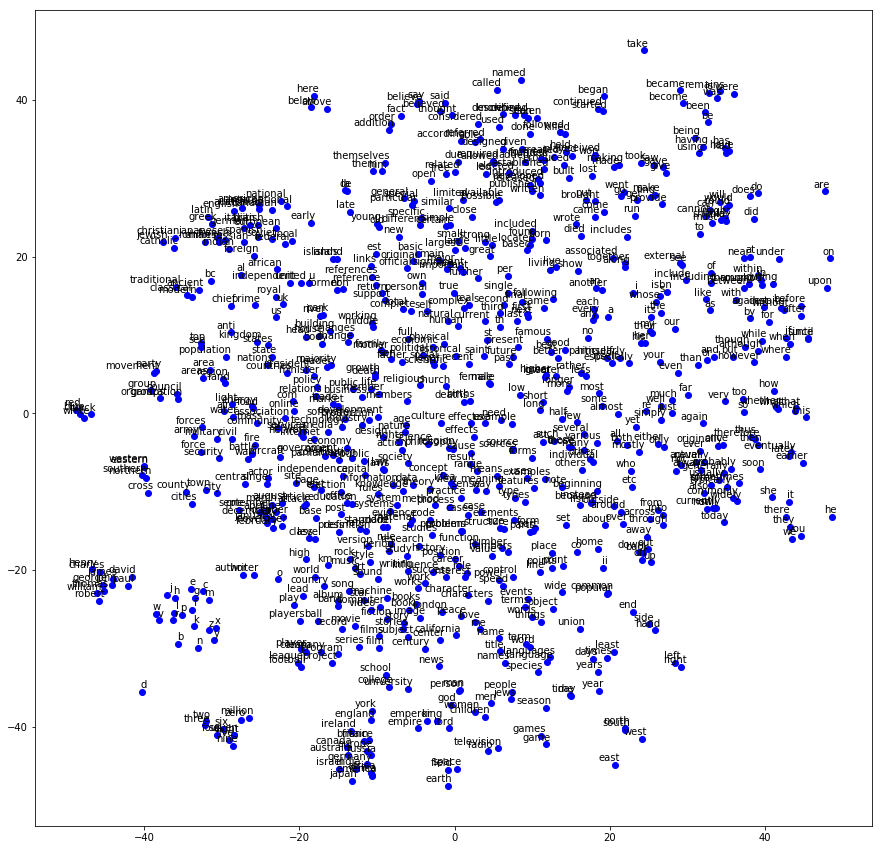

In [12]:
from matplotlib import pylab
from sklearn.manifold import TSNE

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y, color="blue")
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

visualization_words = 800
# transform embeddings to 2D by t-SNE
embed = model_CBOW.embedding_matrix()[1:visualization_words+1,:]
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embed = tsne.fit_transform(embed)
# list labels
words = [model_CBOW.reverse_dictionary[i] for i in range(1, visualization_words+1)]
# plot
plot(two_d_embed,words)

### Reference
* https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/5_word2vec.ipynb